In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import titanic_tools

In [2]:
columns = ['Survived', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Name', 'Age', 'Embarked', 'Ticket']
traindf = pd.read_csv('train.csv', usecols=columns).set_index('PassengerId',)
testdf = pd.read_csv('test.csv', usecols=columns[1:]).set_index('PassengerId')
df = pd.concat([traindf, testdf], axis=0, sort=False)

df.Sex.replace({'male':1, 'female':0}, inplace=True)
df['FamilySize'] = df.SibSp + df.Parch + 1

df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df.Title.replace('Ms','Miss')
df['Title'] = df.Title.replace('Mlle','Miss')
df['Title'] = df.Title.replace('Mme','Mrs')
df['Title'] = df.Title.apply(titanic_tools.replace_not_important_with_others)
df.drop('Name',axis=1, inplace=True)

df['Mother'] = np.where((df.Title=='Mrs') & (df.Parch >0), 1, 0)

df['Ticket'] = df.Ticket.apply(titanic_tools.extract_ticket_type)

df.Age.fillna(df.Title, inplace=True)
df.Age = df.Age.apply(titanic_tools.get_age_by_title)
df.drop('Title',axis=1, inplace=True)

df.Fare.fillna(13,inplace=True)
df.Embarked.fillna('S',inplace=True)

df = pd.get_dummies(df)

df.drop(['Embarked_Q','Parch', 'SibSp', 'Ticket_NO', 'Ticket_OTHER_TICKET'],axis=1, inplace=True)


In [3]:
df.head(10)

,Survived,Pclass,Sex,Age,Fare,FamilySize,Mother,Ticket_A,Ticket_CA,Ticket_PC,Ticket_SOTON,Ticket_WC,Embarked_C,Embarked_S
PassengerId,,,,,,,,,,,,,,
1,0.0,3,1,22.0,7.2500,2,0,1,0,0,0,0,0,1
2,1.0,1,0,38.0,71.2833,2,0,0,0,1,0,0,1,0
3,1.0,3,0,26.0,7.9250,1,0,0,0,0,1,0,0,1
4,1.0,1,0,35.0,53.1000,2,0,0,0,0,0,0,0,1
5,0.0,3,1,35.0,8.0500,1,0,0,0,0,0,0,0,1
6,0.0,3,1,32.0,8.4583,1,0,0,0,0,0,0,0,0
7,0.0,1,1,54.0,51.8625,1,0,0,0,0,0,0,0,1
8,0.0,3,1,2.0,21.0750,5,0,0,0,0,0,0,0,1
9,1.0,3,0,27.0,11.1333,3,1,0,0,0,0,0,0,1


In [4]:
df[['Pclass','FamilySize','Fare', 'Age']] = StandardScaler().fit_transform(df[['Pclass','FamilySize','Fare','Age']])
df.head(5)

,Survived,Pclass,Sex,Age,Fare,FamilySize,Mother,Ticket_A,Ticket_CA,Ticket_PC,Ticket_SOTON,Ticket_WC,Embarked_C,Embarked_S
PassengerId,,,,,,,,,,,,,,
1,0.0,0.841916,1,-0.596458,-0.503265,0.073352,0,1,0,0,0,0,0,1
2,1.0,-1.546098,0,0.617007,0.734759,0.073352,0,0,0,1,0,0,1,0
3,1.0,0.841916,0,-0.293092,-0.490215,-0.558346,0,0,0,0,1,0,0,1
4,1.0,-1.546098,0,0.389482,0.383202,0.073352,0,0,0,0,0,0,0,1
5,0.0,0.841916,1,0.389482,-0.487798,-0.558346,0,0,0,0,0,0,0,1


In [5]:
X = df.loc[traindf.index].drop(['Survived'],axis=1)
y = df.Survived.loc[traindf.index]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state=42)

In [7]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train,y_train);

In [8]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       157
         1.0       0.78      0.75      0.76       111

    accuracy                           0.81       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268



## features selection:

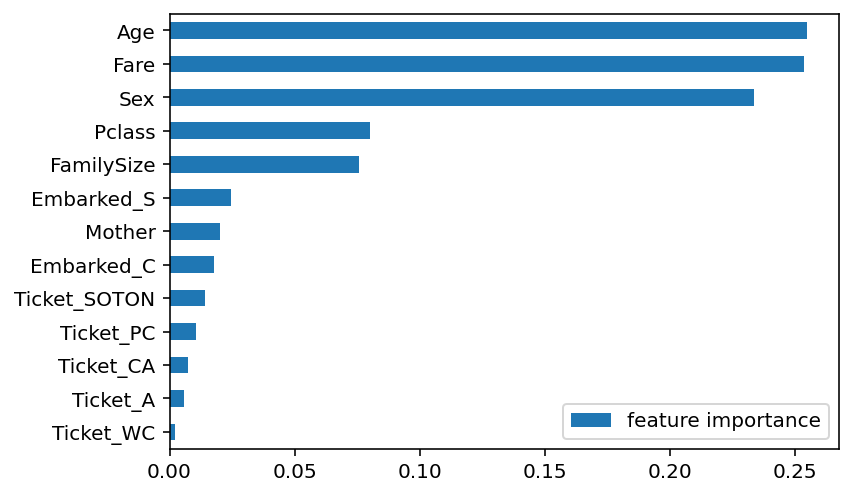

In [9]:
pd.DataFrame(classifier.feature_importances_, index=X.columns, columns=['feature importance'])\
.sort_values('feature importance').plot(kind='barh');

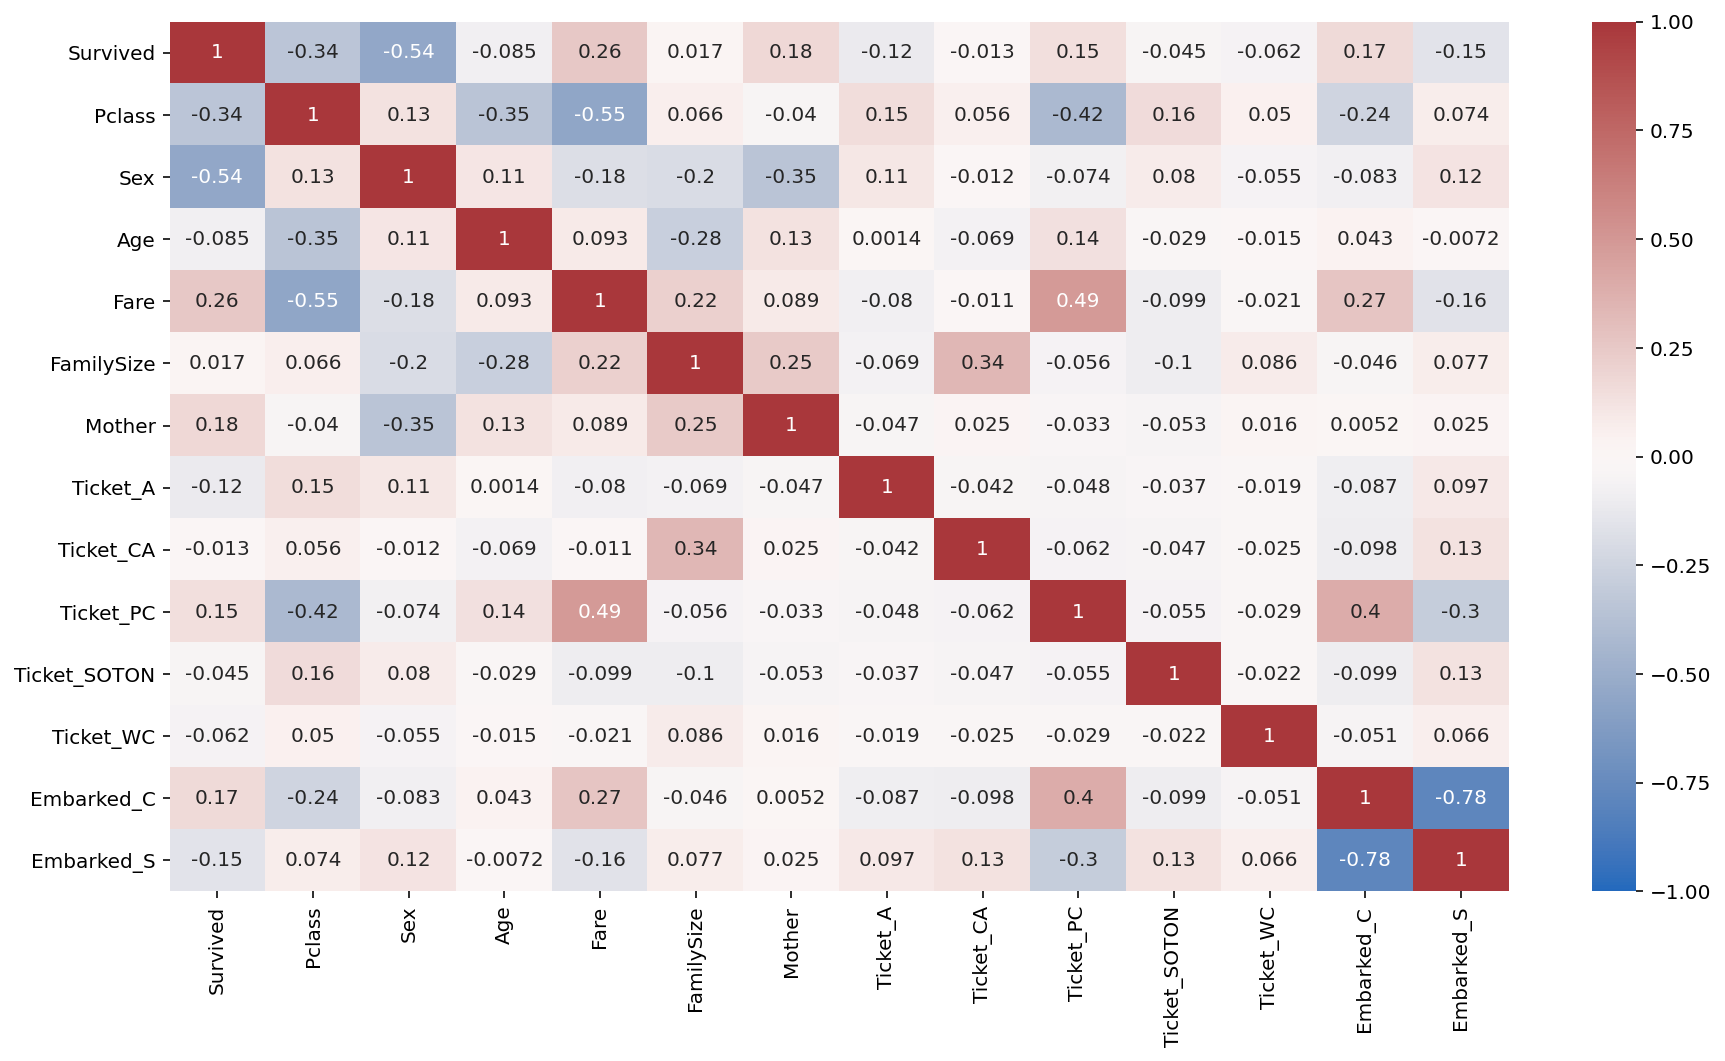

In [10]:
plt.figure(figsize=(15,8))
sns.heatmap(df.loc[traindf.index].corr(),center=0,vmin=-1, vmax=1,cmap='vlag', annot=True);

# model selection:

In [11]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost

In [12]:
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

for model in [
    LogisticRegression,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier]:
    cls = model()
    s = cross_val_score(cls, X, y, scoring="roc_auc", cv=kfold)

    print(f"{model.__name__ :22} AUC: {s.mean(): .3f} STD: {s.std(): .2f}")

LogisticRegression     AUC:  0.856 STD:  0.01
SVC                    AUC:  0.862 STD:  0.01
RandomForestClassifier AUC:  0.873 STD:  0.02
XGBClassifier          AUC:  0.870 STD:  0.02


## let's consider RandomForest & XGB models
### 1. RandomForestClassifier

In [22]:
parameters = {'n_estimators':range(200,1000,200),
              'max_depth': range(4,12,2)}
rf_clf = GridSearchCV(RandomForestClassifier(random_state=42), parameters, cv=kfold, n_jobs=-1,scoring='f1_weighted')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state=42)
rf_clf.fit(X_train, y_train)
rf_predicted = rf_clf.predict(X_test)

print('RandomForest:')
print(classification_report(y_test, rf_predicted))
print('\n' + str(rf_clf.best_estimator_))

RandomForest:
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.86       157
         1.0       0.84      0.70      0.76       111

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268


RandomForestClassifier(max_depth=10, n_estimators=800, random_state=42)


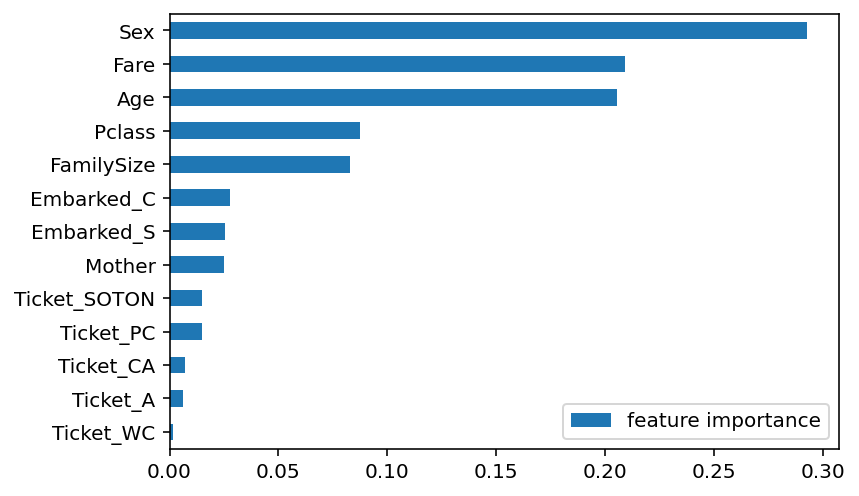

In [14]:
pd.DataFrame(rf_clf.best_estimator_.feature_importances_, index=X.columns, columns=['feature importance'])\
.sort_values('feature importance').plot(kind='barh');

In [63]:
parameters = {'learning_rate': np.arange(0.005,0.3, 0.005),
              'max_depth': [6],
              'min_child_weight': [5],
              'subsample': [0.8],
              'colsample_bytree': [0.8],
              'n_estimators': [1500]}
xgb_clf = GridSearchCV(xgboost.XGBClassifier(random_state=42), parameters, n_jobs=-1, 
                       cv=kfold, scoring='f1_weighted', refit=True)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state=42)
xgb_clf.fit(X_train, y_train)
xgb_predicted = xgb_clf.predict(X_test)

print(classification_report(y_test, xgb_predicted))
print('\n' + str(xgb_clf.best_estimator_))

              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       157
         1.0       0.82      0.76      0.79       111

    accuracy                           0.83       268
   macro avg       0.83      0.82      0.82       268
weighted avg       0.83      0.83      0.83       268


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=1500, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)


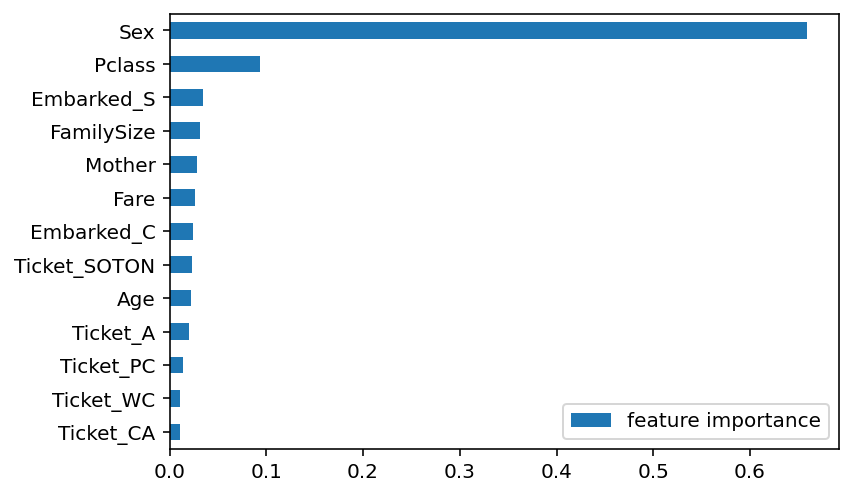

In [61]:
pd.DataFrame(xgb_clf.best_estimator_.feature_importances_, index=X.columns, columns=['feature importance'])\
.sort_values('feature importance').plot(kind='barh');

In [17]:
rf_score = f1_score(y_test, rf_predicted, average='weighted')
xgb_score = f1_score(y_test, xgb_predicted, average='weighted')
predictor = xgb_clf.best_estimator_ if xgb_score > rf_score else rf_clf.best_estimator_

In [18]:
predictdf = df.loc[testdf.index].drop(['Survived'],axis=1)
submission = pd.DataFrame({'PassengerId':predictdf.index,'Survived':predictor.predict(predictdf)})
submission.Survived = submission.Survived.astype(int)
submission.set_index('PassengerId',inplace=True)
submission.to_csv("titanic_submission_result.csv")